In [1]:
# Plotting tools
import pandas as pd
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import json
import re
import spacy
import ast
import string
from spacy import displacy
from spacy.pipeline import merge_entities
from collections import Counter, defaultdict
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel, LdaModel, AuthorTopicModel
from gensim.test.utils import datapath
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from pprint import pprint

In [3]:
nlp = spacy.load('en_core_web_sm')
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "ca"}]], {"LEMMA": "can"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "’ve"}]], {"LEMMA": "have"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "’d"}]], {"LEMMA": "have"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "’ll"}]], {"LEMMA": "will"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "’re"}]], {"LEMMA": "be"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "’m"}]], {"LEMMA": "be"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "’s"}]], {"LEMMA": "be"})
nlp.get_pipe("attribute_ruler").add([[{"LOWER": "n’t"}]], {"LEMMA": "not"})
nlp.add_pipe("merge_entities") # Merge named entities into a single token

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [4]:
authors = ['Emma Brockes', 'Oliver Burkeman', 'Aditya Chakrabortty', 
           'Nick Cohen', 'Victoria Coren Mitchell', 'Barbara Ellen',
           'Will Hutton', 'Simon Jenkins', 'David Mitchell',   
           'George Monbiot', 'Andrew Rawnsley', 'Polly Toynbee']

author2doc = dict()
for author, index in zip(authors, list(range(len(authors)))):
    author2doc[author] = list(range((index+1)*100-100, (index+1)*100))

In [135]:
def print_pos(token):
    return (token.tag_)

def pos_tags(string):   
    tokens = nlp(string)
    tags = []
    for token in tokens:
        tags.append((token, print_pos(token)))
    return tags

def named_ents(string):
    tokens = nlp(string)
    for ent in tokens.ents:
        labels = [ent.label_ for ent in tokens.ents]
        print(Counter(labels))
        return [(ent.text, ent.label_) for ent in tokens.ents]
    
def get_phrases(texts):
#     bigrams = []
    bigram = Phrases(texts, min_count=5, threshold=100)
#     bigram_model = Phraser(bigram)
#     for bigram in bigram_model.phrasegrams.keys():
#         bigrams.append(bigram)
#     print(len(bigrams))
    return [bigram[text] for text in texts]

def get_tokens(texts):
    return [TreebankWordTokenizer().tokenize(text) for text in texts]
    
def get_lemmas(texts, labels):
#     allowed_postags = ['NOUN', 'ADJ', 'VERB']
#     lemmas = []
#     # This will make sure that NE are not lemmatized 
#     # and NE with "bad" labels are ignored
#     for text in texts:
#         lemmas.append([word.lemma_.lower().rstrip() if not word.ent_type_ 
#                        and word.pos_ in allowed_postags
#                        else str(word).replace(' ', '_').lower().rstrip() 
#                        if word.ent_type_ not in labels 
#                        else ''
#                        for word in nlp(text)])
#     with open("lemmas.json", 'w') as fh:
#         json.dump(lemmas, fh, indent=4)
    with open("lemmas.json", 'r') as f:
        lemmas = json.load(f)
    return lemmas

def clean_texts(texts):
    remove = string.punctuation
    remove = remove.replace('-', '').replace('_', '').replace('’', '')
    remove = remove.replace('@', '').replace('.', '')
    pattern = r"[{}]".format(remove)
    texts = [[word.rstrip('.') for word in text if '@' not in word and not '.com' in word
             and not '.co' in word and not '.org' in word and not '.net' in word
             and not '.gov' in word] 
             for text in texts]
    texts = [[re.sub(pattern, '', word) for word in text] for text in texts]
    return texts
    
def remove_stopwords(texts):
    stopwords = ["guardian", "the_guardian", "theguardian.com", "jenkins", "simon_jenkins",
                 "brockes", "emma_brockes", "burkeman", "oliver_burkeman", "chakrabortty",
                 "aditya_chakrabortty", "cohen", "nick_cohen", "mitchell", "david_mitchell",
                 "ellen", "barbara_ellen", "hutton", "will_hutton", "monbiot",
                 "george_monbiot", "rawnsley", "andrew_rawnsley", "toynbee", "polly_toynbee",
                 "illustration_david_foldvari"]
#     with open('sw_extended.txt') as fh:
#         words = fh.read().split(',')
#         stopwords.extend(words)
#     fh.close()
    texts = [[word for word in text if word.rstrip().lower() not in set(stopwords)] 
              for text in texts]
    return texts
    
def remove_bad_pos(texts):    
#     # Remove tokens with certain POS tags
#     stoplist = []
#     bad_postags = ['ADV', 'ADP', 'CONJ', 'CCONJ', 'INTJ', 'PUNCT', 'SPACE', 
#                    'SYM', 'SCONJ', 'PRON', 'PART', 'NUM', 'DET', 'AUX']
#     texts = [' '.join(text) for text in texts]    
#     for text in texts:
#         for word in nlp(text):
#             if word.pos_ in bad_postags:
#                 if '_' not in word.text:
#                     stoplist.append(str(word))    
#     with open('undelete.txt') as fh:
#         good_words = fh.read().split(' ')
#         for word in stoplist:
#             if word in good_words:
#                 stoplist.remove(word)
#     fh.close()           
    with open('stoplist_set.txt','r', encoding='utf-8') as f:
        stoplist = ast.literal_eval(f.read())       
    texts = [[word for word in text if word not in stoplist]
             for text in texts]
    return texts

def fix_length(texts):
    good_words = ['uk', 'us', 'ed', 'dj', 'iq', 'eu', 'pc', 'ai']                    
    return [[word if word in good_words else word if len(word) > 2 
             else '' for word in text] 
             for text in texts]

def fix_empty(texts):
    return [[word for word in text if word] for text in texts]

def fix_rstrip(texts):
    return [[word.rstrip('_') for word in text if word] for text in texts]

In [136]:
js_docs = []

n = 100 # Number of texts by a given author
for author, index in zip(authors, list(range(len(authors)))):
    with open(f"texts_{(index+1):02d}_{author.replace(' ', '_')}.json", 'r') as f:
        js = json.load(f)

        for i in range(0, n):
            js_text = js['Texts'][i]['Full text']
            js_text = re.sub(r"’s", '', js_text)
            js_docs.append(js_text)

In [138]:
# Tokenize
tokenized = get_tokens(js_docs)
tokenized = [' '.join(text) for text in tokenized]

# # Save the tokenized list
# with open("tokenized.json", 'w') as f:
#     json.dump(tokenized, f, indent=4)

# # Show POS tags of each token
# for text in tokenized:
#     print(pos_tags(' '.join(text))) 

# # Show all named entities
# for text in tokenized:
#     print(f"{named_ents(' '.join(text))}\n")

# Lemmatize with an appropriate POS tag
bad_labels = ('DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL')
lemmatized = get_lemmas(tokenized, bad_labels)

# Remove punctuaion
lemmatized = clean_texts(lemmatized)

# Remove common words, digits, etc.
lemmatized = remove_stopwords(lemmatized)
lemmatized = remove_bad_pos(lemmatized)

# Delete emply tokens
lemmatized = fix_empty(lemmatized)

# Remove some _
lemmatized = fix_rstrip(lemmatized)

# Fix some mistakes re: the word length
lemmatized = fix_length(lemmatized)

# Retrieve collocations
lemmatized = get_phrases(lemmatized)

# Fix again
lemmatized = remove_stopwords(lemmatized)

# Save the lemmatized list
with open("lemmatized.json", 'w') as f:
    json.dump(lemmatized, f, indent=4)

In [5]:
# Load the lemmatized list
with open("lemmatized.json", 'r') as fh1:
    lemmatized = json.load(fh1)

# Load the tokenized list
with open("tokenized.json", 'r') as fh2:
    tokenized = json.load(fh2)

count = 0
for item in lemmatized:
    count += len(item)
print(count)

501217


In [47]:
# Map each token to a unique ID
dictionary = corpora.Dictionary(lemmatized)
print(f'Number of unique tokens: {len(dictionary)}')

# Filter out words that occur in less than 10 documents, or more than 85% of the documents
min_doc, max_doc = 20, .2
dictionary.filter_extremes(no_below=min_doc, no_above=max_doc)
print(f'Number of unique tokens (filtered): {len(dictionary)}')

# Create a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in lemmatized]
print(f'Number of documents: {len(corpus)}')

# id_words = [[(dictionary[id], count) for id, count in line] for line in corpus]
# print(id_words)

Number of unique tokens: 34774
Number of unique tokens (filtered): 3162
Number of documents: 1200


In [36]:
## from lda_model_modify import modify_lda_inference
# modify_lda_inference()
from gensim.models import LdaModel


data_dir_lda = 'C:\\Users\\satan\\Desktop\\TM'
tmp = datapath(data_dir_lda + '\\tmp\\model.ldamodel')

# Set training parameters
num_topics = 15
random_state = 100
chunksize = len(corpus)
passes = 150
alpha = .9099999999999999
eta = .9099999999999999
iterations = 100
eval_every = 5

In [37]:
# Run LDA using Bag of Words
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                     random_state=random_state, chunksize=chunksize, 
                     passes=passes, alpha=alpha, eta=eta, iterations=iterations,
                     eval_every=eval_every)

In [42]:
# Save the model
lda_model.save(tmp)

In [193]:
# Load the model
lda_model = LdaModel.load(tmp)

In [38]:
topic_labels = ['Выборы в парламент', 'Коронавирус и здравоохранение', 'Кино и телевидение',
                'Экология', 'Брексит', 'Ближний восток и терроризм', 'Образование',
                'Развлечения и технологии', 'Психология', 'Фильмы и персонажи',
                'Борьба за независимость', 'Книги', 'Политика США', 'Финансы', 
                'Жилищный вопрос и инфраструктура', 'Преступления и вредные привычки', 'Покер']

In [39]:
top_topics = lda_model.top_topics(corpus)

# top_terms = {f'{topic}:': ', '.join([word for word, prob in lda_model.show_topic(i, topn=15)])
#                       for i, topic in zip(range(0, lda_model.num_topics), topic_labels)}
# for key, value in top_terms.items():
#     print(key, value)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'\nAverage topic coherence: {avg_topic_coherence}')

pprint(lda_model.print_topics(num_words=15))

# for item, topic in zip(range(0, lda_model.num_topics), topic_labels):
#     print(f"Тема: {topic}\nТоп-слова: {lda_model.print_topic(item, topn=15).replace(' +', ',')}\n")


Average topic coherence: -1.9514814992174858
[(0,
  '0.009*"land" + 0.007*"environmental" + 0.005*"climate" + 0.005*"nation" + '
  '0.005*"population" + 0.005*"car" + 0.005*"common" + 0.005*"seek" + '
  '0.005*"propose" + 0.005*"space" + 0.005*"impact" + 0.005*"rich" + '
  '0.004*"global" + 0.004*"natural" + 0.004*"produce"'),
 (1,
  '0.014*"johnson" + 0.010*"referendum" + 0.009*"corbyn" + 0.008*"parliament" '
  '+ 0.007*"cabinet" + 0.006*"tories" + 0.006*"boris_johnson" + '
  '0.006*"majority" + 0.005*"theresa" + 0.005*"jeremy_corbyn" + '
  '0.004*"conservative" + 0.004*"speech" + 0.004*"europe" + 0.004*"european" + '
  '0.004*"minister"'),
 (2,
  '0.011*"trade" + 0.011*"bank" + 0.008*"financial" + 0.007*"investment" + '
  '0.007*"europe" + 0.006*"value" + 0.006*"finance" + 0.005*"sector" + '
  '0.005*"debt" + 0.005*"european" + 0.005*"society" + 0.005*"capitalism" + '
  '0.005*"price" + 0.005*"tax" + 0.005*"industry"'),
 (3,
  '0.010*"facebook" + 0.008*"online" + 0.008*"amazon" + 0.

In [40]:
# # Compute perplexity
# print(f'Perplexity:', lda_model.log_perplexity(corpus)) # the lower the better

# Compute coherence score using CV
coherence_c_v_model = CoherenceModel(model=lda_model, texts=lemmatized, 
                                     dictionary=dictionary, coherence='c_v')
coherence_c_v = coherence_c_v_model.get_coherence()
print(f'Coherence score (c_v): {coherence_c_v}') # 0.65 is good, 0.7 is excellent

# Compute coherence score using UMass
coherence_umass_model = CoherenceModel(model=lda_model, texts=lemmatized, 
                                       dictionary=dictionary, coherence="u_mass")
coherence_umass = coherence_umass_model.get_coherence()
print(f'Coherence score (UMass): {coherence_umass}') # should be close to 0

Coherence score (c_v): 0.5430493178532555
Coherence score (UMass): -1.9514814992174863


In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [12]:
data_dir_atm = 'C:\\Users\\satan\\Desktop\\TM'

# Set training parameters
num_topics = 8
chunksize = len(corpus)
passes = 150
iterations = 100
eval_every = 1
alpha = .9099999999999999
eta = .21
random_state = 100

In [105]:
# Train several models
model_list = []
for i in range(1, 5):
    atm_model = AuthorTopicModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                                 author2doc=author2doc, chunksize=chunksize, passes=passes,
                                 gamma_threshold=1e-10, eval_every=eval_every,
                                 iterations=iterations, random_state=i, alpha=alpha, eta=eta,
                                 minimum_probability=0.01)
    top_topics = atm_model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    model_list.append((atm_model, tc))

# Choose the model with the highest topic coherence
atm_model, tc = max(model_list, key=lambda x: x[1])
print('Topic coherence: %.3e' %tc)

Topic coherence: -1.323e+01


In [30]:
# Save the model
atm_model.save(data_dir_atm + '\\tmp\\model.atmodel')

In [108]:
# Load the model
atm_model = AuthorTopicModel.load(data_dir_atm + '\\tmp\\model.atmodel')

In [28]:
topic_labels = ['Экология', 'Правительство', 'Финансы',
                'Психология', 'Местные власти и бюджет',
                'Покер', 'Политика США', 'Книги и фильмы']

In [17]:
atm_model = AuthorTopicModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                             author2doc=author2doc, chunksize=chunksize, passes=passes,
                             eval_every=eval_every, iterations=iterations,
                             random_state=random_state, alpha=alpha, minimum_probability=0.01)

In [24]:
# pprint(atm_model.print_topics(num_words=15))
   
# for item, topic in zip(range(0, atm_model.num_topics), topic_labels):
#     print(f"Тема: {topic}\nТоп-слова: {atm_model.print_topic(item, topn=15).replace(' +', ',')}\n")
    
top_terms = {f'{topic}:': ', '.join([word for word, prob in atm_model.show_topic(i, topn=15)])
                      for i, topic in zip(range(0, atm_model.num_topics), topic_labels)}
for key, value in top_terms.items():
    print(key, value)

Экология: land, seek, environmental, car, nation, democracy, population, propose, rich, impact, common, animal, natural, reduce, water
Правительство: tories, cabinet, conservative, minister, johnson, referendum, parliament, opposition, majority, corbyn, europe, speech, conservatives, david_cameron, boris_johnson
Финансы: bank, trade, europe, society, value, investment, financial, european, china, tax, capitalism, debt, growth, sector, private
Психология: experience, person, choice, news, sort, happy, important, choose, suppose, truth, fun, brain, study, attention, society
Местные власти и экономика: local, council, tax, johnson, staff, worker, nhs, minister, austerity, budget, housing, parliament, community, death, corbyn
Покер: poker, bet, card, player, game, sex, sort, event, film, sit, machine, shop, tournament, full, raise
Политика США: trump, police, liberal, crime, johnson, war, judge, russia, accept, journalist, attack, court, american, law, west
Книги и фильмы: kid, parent, mot

In [29]:
def show_author(name):
    print('\n%s' % name)
    print('Topics:')
    pprint([(topic_labels[topic[0]], topic[1]) for topic in atm_model[name]])
    
    
for author in authors:
#     print(f'{author}: {atm_model[author]}')   
    show_author(author)


Emma Brockes
Topics:
[('Книги и фильмы', 0.9756855467821446)]

Oliver Burkeman
Topics:
[('Психология', 0.9809420812363658), ('Книги и фильмы', 0.01449133392570114)]

Aditya Chakrabortty
Topics:
[('Правительство', 0.05796860903137021),
 ('Финансы', 0.17534770844900774),
 ('Местные власти и бюджет', 0.6337954265133703),
 ('Книги и фильмы', 0.12840284858095388)]

Nick Cohen
Topics:
[('Правительство', 0.29214373157767454),
 ('Финансы', 0.10210609130101202),
 ('Местные власти и бюджет', 0.012845868446566131),
 ('Политика США', 0.5820411816110683)]

Victoria Coren Mitchell
Topics:
[('Психология', 0.057520307153766735),
 ('Местные власти и бюджет', 0.010166285445126145),
 ('Покер', 0.76214562785392),
 ('Политика США', 0.03404624422546884),
 ('Книги и фильмы', 0.13209567755773388)]

Barbara Ellen
Topics:
[('Психология', 0.13946289428444747),
 ('Местные власти и бюджет', 0.032104284780529194),
 ('Покер', 0.031075448666693862),
 ('Политика США', 0.259932616162828),
 ('Книги и фильмы', 0.5348868

In [19]:
# Compute coherence score using CV
coherence_c_v_model = CoherenceModel(model=atm_model, texts=lemmatized, 
                                     dictionary=dictionary, coherence='c_v')
coherence_c_v = coherence_c_v_model.get_coherence()
print(f'Coherence score (c_v): {coherence_c_v}') # 0.65 is good, 0.7 is excellent

# Compute coherence score using UMass
coherence_umass_model = CoherenceModel(model=atm_model, texts=lemmatized, 
                                       dictionary=dictionary, coherence="u_mass")
coherence_umass = coherence_umass_model.get_coherence()
print(f'Coherence score (UMass): {coherence_umass}') # should be close to 0

Coherence score (c_v): 0.49598593942714475
Coherence score (UMass): -1.6944238566430585


In [182]:
# Hyperparameter tuning
from gensim.utils import ClippedCorpus
import pandas as pd
import tqdm


def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=k, 
                         random_state=100,
                         chunksize=1200,
                         passes=10,
                         alpha=a,
                         eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized, 
                                         dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()


grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 5
max_topics = 30
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(.01, 1, .3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(.01, 1, .3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*.5), 
               ClippedCorpus(corpus, int(num_of_docs*.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run (=9h30m)
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

1500it [15:58:53, 38.36s/it]                                                                                           


In [193]:
# Show hyperparameter tuning results
import csv


with open('lda_tuning_results_3.csv', newline='') as csvfile:
    rdr = csv.reader(csvfile)
    l = sorted(rdr, key=lambda x: x[4], reverse=True)
    
pprint(l[:10])

[['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'],
 ['75% Corpus',
  '5',
  '0.9099999999999999',
  '0.9099999999999999',
  '0.48616666632536465'],
 ['75% Corpus', '5', '0.31', '0.9099999999999999', '0.48537726598147046'],
 ['75% Corpus', '5', '0.61', '0.9099999999999999', '0.48415909548944336'],
 ['75% Corpus', '5', '0.01', '0.61', '0.4810819446440867'],
 ['75% Corpus', '5', 'asymmetric', '0.31', '0.4799796508126171'],
 ['75% Corpus', '5', 'symmetric', '0.61', '0.4780745762984265'],
 ['75% Corpus', '5', '0.01', '0.9099999999999999', '0.47807453129571115'],
 ['75% Corpus', '5', '0.31', '0.61', '0.47803620498984617'],
 ['75% Corpus', '5', '0.9099999999999999', '0.61', '0.47773205102587246']]


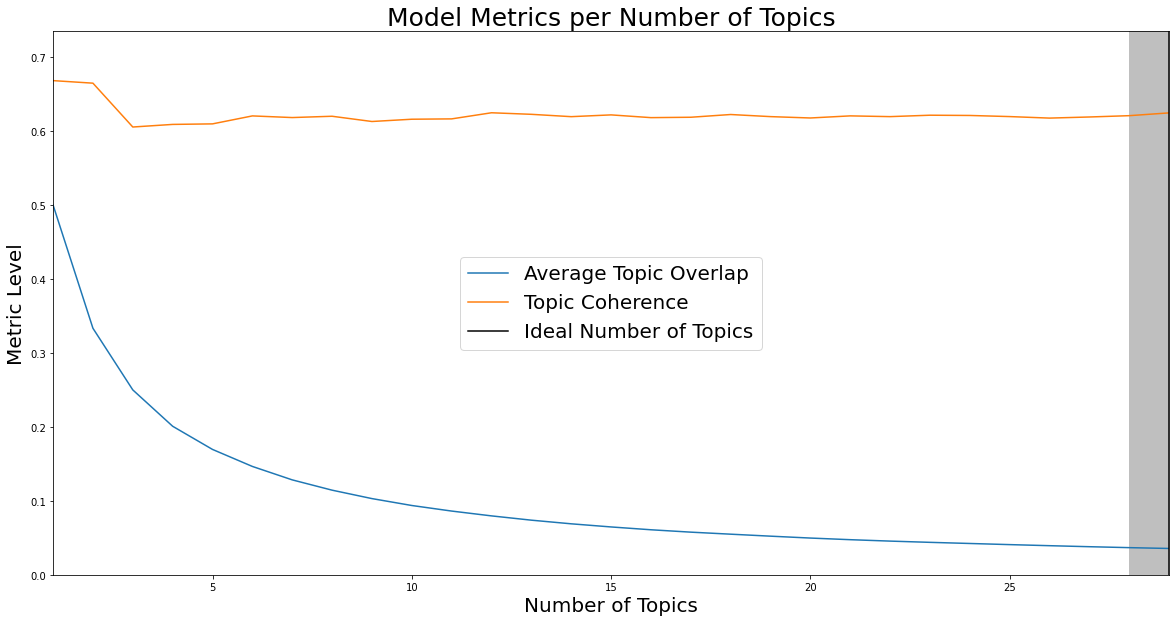

In [29]:
# Find the optimal number of topics
# https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin
import seaborn as sns
import six


def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))


# Considering 1-25 topics, as the last is cut off
num_topics = list(range(31)[1:])
num_keywords = 30

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=i,
                             chunksize=len(corpus),
                             passes=10,
                             alpha=.31,
                             random_state=100)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]   

coherences = [CoherenceModel(model=LDA_models[i], texts=lemmatized, dictionary=dictionary, 
                             coherence='c_v').get_coherence()
              for i in num_topics[:-1]]

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

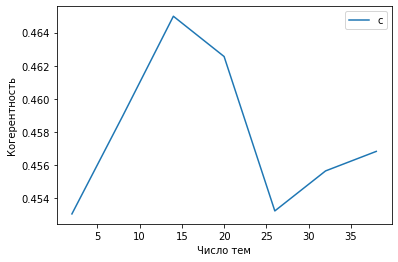

In [34]:
# Find the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = AuthorTopicModel(corpus=corpus, id2word=dictionary) # or LdaModel
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                        texts=lemmatized, start=2, limit=40, step=6)

# Show graph
limit=40; start=2; step=6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Число тем")
plt.ylabel("Когерентность")
plt.legend(("coherence_values"), loc='best')
plt.show()